In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,MaxPool2D,AvgPool2D, Dense,Flatten,Activation,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint


In [13]:
#Initializations

imgsize = 224 
batchSize = 32
lr = 0.0001  #Learning Rate
epch = 25  #Number of Epochs

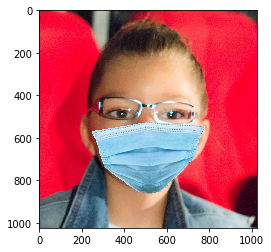

In [3]:
#Load a test image 
train_dir = "dataset/train/"
test_dir = "dataset/test/"
img = image.load_img(train_dir+"covered/16523_Mask.jpg")
plt.imshow(img)


In [9]:
#Load/Transform Train and Validation data 

dataGenerator = ImageDataGenerator(#rescale=1/255,  #Commented, Since using mobilenet preprocessor for better accuracy
                                    preprocessing_function=preprocess_input, #Using default preprocessing for mobilenet
                                    rotation_range=30,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    validation_split=0.30) 


# This will auto generate labels based on directory
train_dataset = dataGenerator.flow_from_directory(train_dir,  
                                          target_size=(imgsize,imgsize),  #To bring all image to same size
                                          batch_size = batchSize,
                                          #color_mode="grayscale",
                                          shuffle=True,
                                          subset="training",
                                          class_mode="categorical")    

validation_dataset = dataGenerator.flow_from_directory(train_dir,  
                                          target_size=(imgsize,imgsize),  #To bring all image to same size
                                          batch_size = batchSize,
                                          #color_mode="grayscale",
                                          shuffle=True,
                                          subset="validation",
                                          class_mode="categorical")

print(train_dataset.class_indices)
print(validation_dataset.class_indices)

Found 88534 images belonging to 2 classes.
Found 37942 images belonging to 2 classes.
{'covered': 0, 'uncovered': 1}
{'covered': 0, 'uncovered': 1}


In [11]:
"""
For speed optimization we will be using Mobilenet, which will be helpful for real time object
detection on videos
"""

mobilenet = MobileNetV2(weights='imagenet',include_top=False,input_shape=(imgsize,imgsize,3)) 

for layer in mobilenet.layers:
    layer.trainable = False
    
headModel = mobilenet.output

#headModel = AvgPool2D(pool_size=(7,7))(headModel)
headModel = Flatten()(headModel)
headModel = Dense(128,activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2,activation='softmax')(headModel)
model = Model(inputs=mobilenet.input, outputs=headModel)

# Alternate Way    
"""
model = Sequential()
model.add(mobilenet)
model.add(AvgPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))
"""

model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [14]:
# Model Compile

print("[INFO] Model compile")

"""
ADAM vs SGD
ADAM finds solutions with much larger weights, which might explain why it has lower test accuracy and is not 
generalizing as well. 
This is why weight decay is recommended with ADAM.
More info: https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e

"""
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr, decay=lr / epch),
              metrics=['accuracy'])




[INFO] Model compile


In [15]:
# checkpoint
filepath="modelAttributes/weights_maskcoverage_v2.best.hdf5"  # serialize best model weight to HDF5
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]


print("[INFO] Model training")

model_fit = model.fit(train_dataset, 
                      batch_size=batchSize, 
                      #steps_per_epoch=len(train_dataset)//batchSize,
                      epochs=epch, 
                      callbacks=callbacks_list,
                      validation_data= validation_dataset)
                      #validation_steps=len(validation_dataset)//batchSize)

[INFO] Model training
Epoch 1/25
2767/2767 [==============================] - ETA: 0s - loss: 0.1671 - accuracy: 0.9359
Epoch 00001: val_accuracy improved from -inf to 0.95991, saving model to modelAttributes/weights_maskcoverage_v2.best.hdf5
2767/2767 [==============================] - 6059s 2s/step - loss: 0.1671 - accuracy: 0.9359 - val_loss: 0.1013 - val_accuracy: 0.9599
Epoch 2/25
2767/2767 [==============================] - ETA: 0s - loss: 0.1109 - accuracy: 0.9578
Epoch 00002: val_accuracy improved from 0.95991 to 0.96753, saving model to modelAttributes/weights_maskcoverage_v2.best.hdf5
2767/2767 [==============================] - 6246s 2s/step - loss: 0.1109 - accuracy: 0.9578 - val_loss: 0.0822 - val_accuracy: 0.9675
Epoch 3/25
2767/2767 [==============================] - ETA: 0s - loss: 0.0978 - accuracy: 0.9641
Epoch 00003: val_accuracy improved from 0.96753 to 0.97098, saving model to modelAttributes/weights_maskcoverage_v2.best.hdf5
2767/2767 [============================

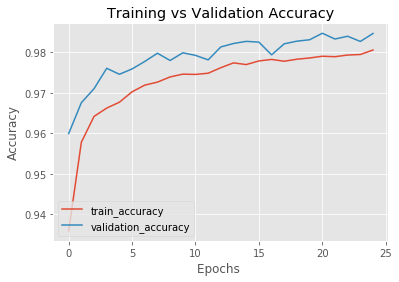

In [16]:
#Plot accuracy graph for better visualization

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,epch), model_fit.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0,epch), model_fit.history["val_accuracy"], label="validation_accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs ")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig("plots/acc_plot_v2.png")

In [17]:
model.save('modelAttributes/maskCoverageModel_v2.h5')

In [18]:
# Testing with the best model weights obtained so far

from tensorflow.keras.models import load_model
loaded_model = load_model('modelAttributes/maskCoverageModel_v2.h5')
loaded_model.load_weights("modelAttributes/weights_maskcoverage_v2.best.hdf5")

#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#test_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(imgsize,imgsize),
    class_mode='categorical',batch_size=32)

scores = loaded_model.evaluate(test_generator, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], scores[1]*100))

Found 7612 images belonging to 2 classes.
accuracy: 99.16%


In [19]:
#test_dir="/Users/sagarsingh20/Documents/OneDrive - Northeastern University/CNN Related/Mask Detection/dataset"
CATEGORIES = ["covered", "uncovered"]

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

test_data = []
test_labels = []

for category in CATEGORIES:
    path = os.path.join(test_dir, category)
    for img in os.listdir(path):
        try:
            if(img == ".DS_Store"):
                continue
            img_path = os.path.join(path, img)
            image = cv2.imread(img_path)
            image = cv2.resize(image,(imgsize,imgsize))
            #image = preprocess_input(image)
            image = image/255.0

            test_data.append(image)
            test_labels.append(category)
        except Exception as e:
            print(img)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
test_labels = lb.fit_transform(test_labels)
test_labels = to_categorical(test_labels)

test_data = np.array(test_data, dtype="float32")
test_labels = np.array(test_labels)
print("[INFO] Done")



[INFO] loading images...
[INFO] Done


In [20]:
# show a nicely formatted classification report

predIdxs = model.predict(test_data, batch_size=batchSize)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(test_labels.argmax(axis=1), predIdxs,target_names=lb.classes_))

              precision    recall  f1-score   support

     covered       0.96      0.94      0.95      3801
   uncovered       0.94      0.96      0.95      3811

    accuracy                           0.95      7612
   macro avg       0.95      0.95      0.95      7612
weighted avg       0.95      0.95      0.95      7612

